## Assignment 1.0: KNN Implementation (mean trials per neighbor)

(Individual)

Using 50 trials, create a mean plot of **Accuracy** vs **n_neighbors** until (n=40) for the three
examples (Iris, Boston Cancer, UPCAT) provided here. Based on the result, comment on the
optimal **n_neighbors**. Submit a Jupyter Notebook.


## Author

Chris Andrei Irag, DS3A


## Outline

- [Libraries](#libraries)
- [Utilities](#utilities)
- [Iris Dataset](#iris)
- [Boston Cancer Dataset](#breast-cancer)
- [UPCAT Dataset](#upcat)



<a id="libraries"></a>
## Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Libraries for explainability
from PIL import Image
from tqdm import tqdm
from loguru import logger
from typing import Tuple, List

from machine_learning.config import FIGURES_DIR
from machine_learning.config import MPLSTYLE_DIR

plt.style.use(MPLSTYLE_DIR / "iragca_ml.mplstyle")

# Datasets
from sklearn.datasets import load_iris, load_breast_cancer
from machine_learning.config import EXTERNAL_DATA_DIR

# Add logger for logging past runs
if "CELL_RAN" not in globals():
    CELL_RAN = True
    logger.add("1.0_KNN-Implementation.log")

2025-02-20 00:42:02.749 | INFO     | machine_learning.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\machine-learning


<a id="utilities"></a>
## Utilities

### Data Loader

This class provides static methods to load various classification datasets which we will use for our KNN implementation. The functions do the preprocessing needed for us.

In [2]:
class DataLoader:
    """A utility class for loading various classification datasets.

    This class provides static methods to load three different datasets:
    - Iris dataset (from sklearn)
    - Breast Cancer dataset (from sklearn) 
    - UPCAT dataset (from external Excel file)

    Each method returns a tuple containing features and target variables as Polars DataFrames/Series.
    """
    @staticmethod
    def load_iris() -> Tuple[pl.DataFrame, pl.Series]:
        iris = load_iris()
        data = pl.DataFrame(
            pd.DataFrame(iris.data, columns=iris.feature_names)
        ).with_columns(pl.Series(name="target", values=iris.target.tolist(), dtype=pl.Int8))
        return data.drop("target"), data["target"]
    
    @staticmethod
    def load_breast_cancer() -> Tuple[pl.DataFrame, pl.Series]:
        cancer = load_breast_cancer()
        data = pl.DataFrame(
            pd.DataFrame(cancer.data, columns=cancer.feature_names)
        ).with_columns(pl.Series(name="target", values=cancer.target.tolist()))
        return data.drop("target"), data["target"]
    
    @staticmethod
    def load_upcat(path: str) -> Tuple[pl.DataFrame, pl.Series]:
        data = pl.read_excel(path).drop_nulls()
        return data.drop("Target"), data["Target"]

This KNN Pipeline class is used to evaluate the performance of the KNN classifier over a range of n_neighbors values essentially doing a grid search over the n_neighbors value. We can also plot the results to visualize the performance of the model.


In [3]:
class KNNPipeline:
    """A pipeline for evaluating K-Nearest Neighbors classifiers.

    This class handles the training, evaluation, and visualization of KNN models
    with support for multiple trials and grid search over different n_neighbors values.

    Attributes:
        features (pl.DataFrame): Input features for classification
        target (pl.Series): Target labels
        data_name (str): Name of the dataset being used
    """

    def __init__(self, features: pl.DataFrame, target: pl.Series, data_name: str):
        self.features = features
        self.target = target
        self.data_name = data_name

    def evaluate(
        self, n_neighbors: int, trials: int = 50, test_size: float = 0.25, _verbose: bool = True
    ) -> Tuple[float, float]:
        """Evaluate KNN model with multiple trials"""
        train_scores, test_scores = [], []

        if _verbose:
            progress_bar = tqdm(
                range(trials), desc=f"KNN ({trials} trials)", unit="trial", leave=False
            )
            logger.info(f"Starting KNN ({trials} trials)")

        for _ in progress_bar if _verbose else range(trials):
            X_train, X_test, y_train, y_test = train_test_split(
                self.features, self.target, test_size=test_size
            )
            model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))

        if _verbose:
            logger.info(f"Finished KNN ({trials} trials)")

        return np.mean(train_scores), np.mean(test_scores)

    def grid_search(
        self, n_neighbors: List[int], trials: int = 50, test_size: float = 0.25,plot: bool = True
    ) -> Tuple[List[float], List[float]]:
        """Perform grid search over different n_neighbors values"""
        logger.info(
            f"Starting Grid Search for {self.data_name}. "
            f"n_neighbors: {n_neighbors}, trials: {trials}"
        )

        train_means, test_means = [], []
        progress_bar = tqdm(
            n_neighbors, desc=f"Grid Search ({trials} trials)", unit="n_neighbors", leave=False
        )

        for n in progress_bar:
            train_mean, test_mean = self.evaluate(n, trials, test_size, _verbose=False)
            train_means.append(train_mean)
            test_means.append(test_mean)

        train_means, test_means = np.array(train_means), np.array(test_means)

        chart = None
        if plot:
            chart = self._plot_results(n_neighbors, train_means, test_means, trials)

        logger.info(
            f"Finished Grid Search for {self.data_name}\n "
            f"Train max accuracy: {train_means.max()}\n "
            f"Test max accuracy: {test_means.max()}"
        )
        return train_means, test_means, self.data_name, chart

    def _plot_results(
        self,
        n_neighbors: List[int],
        train_means: List[float],
        test_means: List[float],
        trials: int,
    ):
        """Plot the grid search results"""
        fig, ax = plt.subplots()

        sns.lineplot(ax=ax, x=n_neighbors, y=train_means, label="Train")
        sns.lineplot(ax=ax, x=n_neighbors, y=test_means, label="Test")

        ax.set_title(f"{self.data_name} KNN Performance ({trials} trials)")
        ax.set_xlabel("Number of Neighbors")
        ax.set_ylabel("Mean Accuracy")

        plt.legend()
        plt.grid()
        plt.show()

        return fig

<a id="iris"></a>
## Iris Dataset


Load the Iris dataset


In [4]:
X_iris, y_iris = DataLoader().load_iris()

iris = (
    X_iris.with_columns(target=y_iris)
)

Let's do some initial EDA

In [5]:
iris.head()

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
f64,f64,f64,f64,i8
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0


In [6]:
iris['target'].unique()

target
i8
0
1
2


We have 4 features:
- sepal length
- sepal width
- petal length
- petal width

We can see that the target is a categorical variable with 3 unique values.

Let's map the target values to the (assumed) corresponding flower names:

0 -> setosa <br>
1 -> versicolor <br>
2 -> virginica <br>


Let's see our data's basic statistics

In [7]:
iris.describe()

statistic,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
str,f64,f64,f64,f64,f64
"""count""",150.0,150.0,150.0,150.0,150.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",5.843333,3.057333,3.758,1.199333,1.0
"""std""",0.828066,0.435866,1.765298,0.762238,0.819232
"""min""",4.3,2.0,1.0,0.1,0.0
"""25%""",5.1,2.8,1.6,0.3,0.0
"""50%""",5.8,3.0,4.4,1.3,1.0
"""75%""",6.4,3.3,5.1,1.8,2.0
"""max""",7.9,4.4,6.9,2.5,2.0


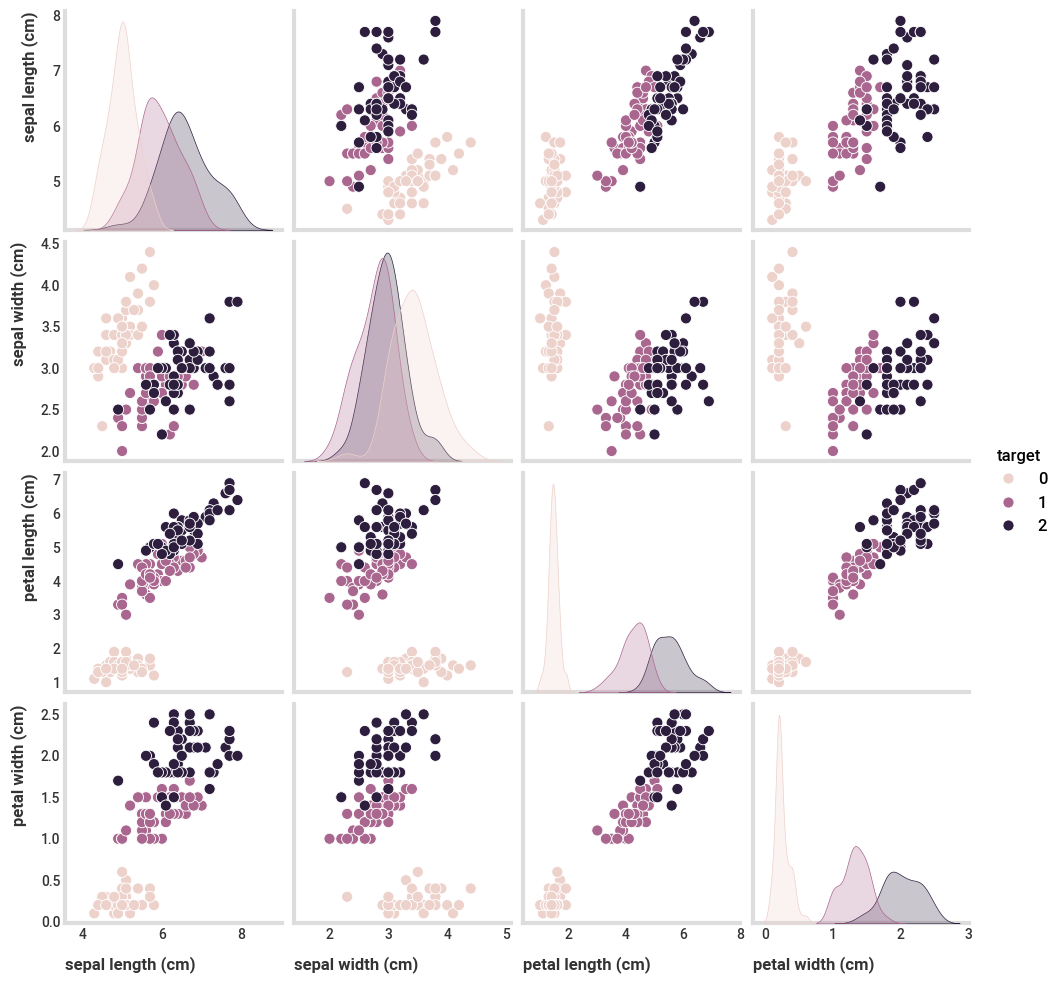

In [8]:
sns.pairplot(iris.to_pandas(), hue='target')

<Axes: >

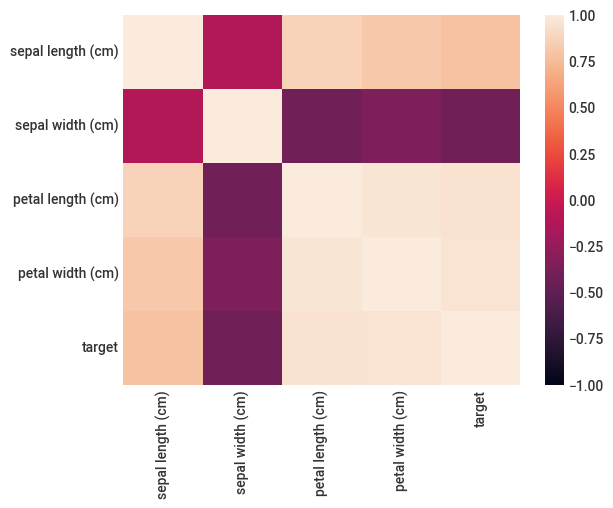

In [9]:
sns.heatmap(iris.to_pandas().corr(), annot=False, vmin=-1, vmax=1)

We can see that sepal width is not correlated with our target, that gives us options to remove it entirely in our model. However, I will leave them be for now to see the performance and use that as a baseline for comparison.

### KNN Implementation and Discussion

Let's build our KNN Pipeline and try to discuss the results.

2025-02-20 00:42:05.394 | INFO     | __main__:grid_search:47 - Starting Grid Search for Iris. n_neighbors: range(1, 41), trials: 50


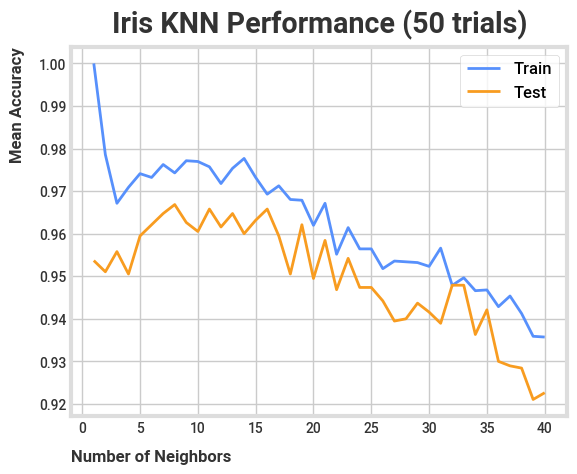

2025-02-20 00:42:26.502 | INFO     | __main__:grid_search:68 - Finished Grid Search for Iris
 Train max accuracy: 1.0
 Test max accuracy: 0.9668421052631578


In [10]:
iris_knn = KNNPipeline(X_iris, y_iris, "Iris")

iris_results = iris_knn.grid_search(range(1, 41), trials=50, plot=True, test_size=0.25)

In [11]:
iris_train_results, iris_test_results, _, iris_chart = iris_results
print(f"""
Training set:
    Best n_neighbor: {iris_train_results.argmax() + 1}
    Best accuracy: {iris_train_results.max()}
    Mean of means: {iris_train_results.mean()}
    Std of means: {iris_train_results.std()}

Test set:
    Best n_neighbor: {iris_test_results.argmax() + 1}
    Best accuracy: {iris_test_results.max()}
    Mean of means: {iris_test_results.mean()}
    Std of means: {iris_test_results.std()}
""")


Training set:
    Best n_neighbor: 1
    Best accuracy: 1.0
    Mean of means: 0.9622544642857143
    Std of means: 0.013961367496275934

Test set:
    Best n_neighbor: 8
    Best accuracy: 0.9668421052631578
    Mean of means: 0.9499342105263157
    Std of means: 0.01240933183618276



We can say that the best n_neighbor is 8 with an accuracy of about 0.97 on the test set for this single iteration.

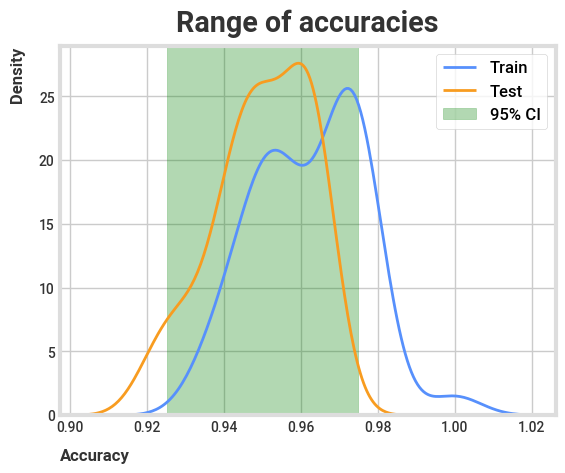

In [12]:
sns.kdeplot(iris_train_results, label='Train')
sns.kdeplot(iris_test_results, label='Test')

iris_mean = iris_test_results.mean()
iris_2std = iris_test_results.std() * 2

plt.axvspan(
    iris_mean - iris_2std, iris_mean + iris_2std,
    color='green', alpha=0.3, label="95% CI"
)
plt.title("Range of accuracies")
plt.xlabel("Accuracy")
plt.grid()
plt.legend()

We can say that in any consecutive runs of this model with a test size of 25% and with 1-40 n_neighbors, our test accuracies will most likely fall around $0.95 \pm 0.0248$ or within two standard deviations of the mean. The distribution is observed to be normal.

<a id="breast-cancer"></a>
## Breast Cancer

In [13]:
# Load the data
X_cancer, y_cancer = DataLoader().load_breast_cancer()

breast_cancer = (
    X_cancer.with_columns(target=y_cancer)
)

Let's do some initial EDA

In [14]:
breast_cancer.head()

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0


In [15]:
breast_cancer['target'].unique()

target
i64
0
1


We have 30 features, and two classes for classification.

Let's see our data's basic statisics

In [16]:
breast_cancer.describe()

statistic,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",14.127292,19.289649,91.969033,654.889104,0.09636,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.26919,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
"""std""",3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.07972,0.038803,0.027414,0.00706,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.00617,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
"""min""",6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,0.0,0.106,0.04996,0.1115,0.3602,0.757,6.802,0.001713,0.002252,0.0,0.0,0.007882,0.0008948,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504,0.0
"""25%""",11.7,16.17,75.17,420.3,0.08637,0.06492,0.02956,0.02031,0.1619,0.0577,0.2324,0.8339,1.606,17.85,0.005169,0.01308,0.01509,0.007638,0.01516,0.002248,13.01,21.08,84.11,515.3,0.1166,0.1472,0.1145,0.06493,0.2504,0.07146,0.0
"""50%""",13.37,18.84,86.24,551.1,0.09587,0.09263,0.06154,0.0335,0.1792,0.06154,0.3242,1.108,2.287,24.53,0.00638,0.02045,0.02589,0.01093,0.01873,0.003187,14.97,25.41,97.66,686.5,0.1313,0.2119,0.2267,0.09993,0.2822,0.08004,1.0
"""75%""",15.78,21.8,104.1,782.7,0.1053,0.1304,0.1307,0.074,0.1957,0.06612,0.4789,1.474,3.357,45.19,0.008146,0.03245,0.04205,0.01471,0.02348,0.004558,18.79,29.72,125.4,1084.0,0.146,0.3391,0.3829,0.1614,0.3179,0.09208,1.0
"""max""",28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,0.2012,0.304,0.09744,2.873,4.885,21.98,542.2,0.03113,0.1354,0.396,0.05279,0.07895,0.02984,36.04,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075,1.0


We plot the interactions using a heatmap instead of pairplot as we have 30, features.

<Axes: >

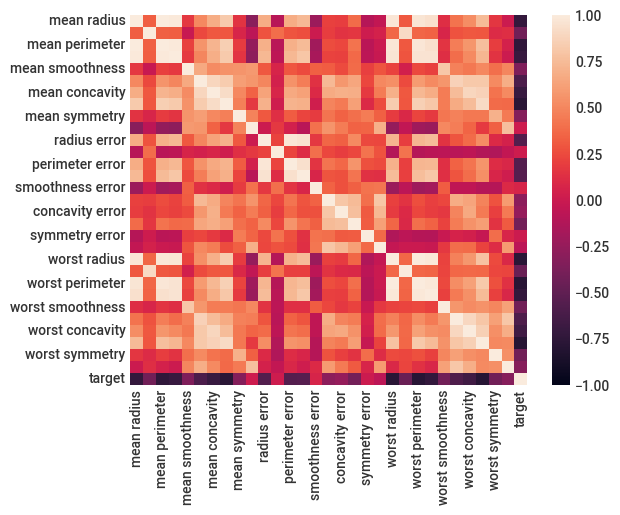

In [17]:
sns.heatmap(breast_cancer.to_pandas().corr(), annot=False, vmin=-1, vmax=1)

We can see that we have some features, that are not correlated with our target, that gives us options to remove them entirely in our model. However, I will leave them be for now to see the performance and use that as a baseline for comparison.

### KNN Implementation and Discussion

Let's build our KNN Pipeline and try to discuss the results.

2025-02-20 00:42:27.242 | INFO     | __main__:grid_search:47 - Starting Grid Search for Breast Cancer. n_neighbors: range(1, 41), trials: 50


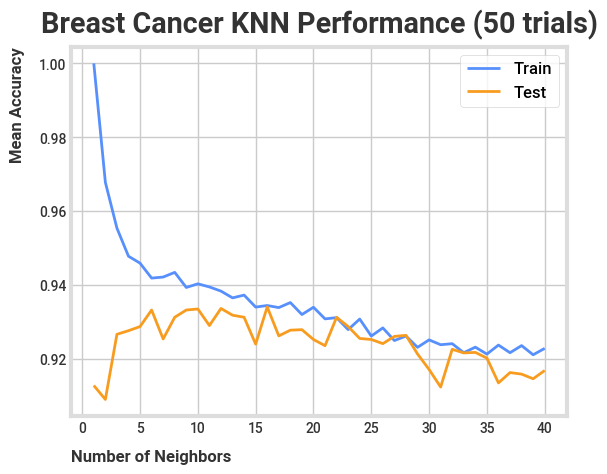

2025-02-20 00:43:33.749 | INFO     | __main__:grid_search:68 - Finished Grid Search for Breast Cancer
 Train max accuracy: 1.0
 Test max accuracy: 0.9341258741258741


In [18]:
# Display the properties of the dataset
bc_KNN = KNNPipeline(X_cancer, y_cancer, "Breast Cancer")

bc_results = bc_KNN.grid_search(range(1, 41), trials=50, plot=True, test_size=0.25)

In [19]:
bc_train_results, bc_test_results, _, bc_chart = bc_results
print(f"""
Training set:
    Best n_neighbor: {bc_train_results.argmax() + 1}
    Best accuracy: {bc_train_results.max()}
    Mean of means: {bc_train_results.mean()}
    Std of means: {bc_train_results.std()}

Test set:
    Best n_neighbor: {bc_test_results.argmax() + 1}
    Best accuracy: {bc_test_results.max()}
    Mean of means: {bc_test_results.mean()}
    Std of means: {bc_test_results.std()}
""")


Training set:
    Best n_neighbor: 1
    Best accuracy: 1.0
    Mean of means: 0.934580985915493
    Std of means: 0.014497994989069313

Test set:
    Best n_neighbor: 16
    Best accuracy: 0.9341258741258741
    Mean of means: 0.9245034965034964
    Std of means: 0.006612678522203154



Based on the chart and the results, it would probably be a good guess that the best neighbors are between 8-15. The mean accuracy would lie around $0.924\pm0.0132$, with a testing set size of 25% from 1-40 neighbors. The distribution is observed to be normal.

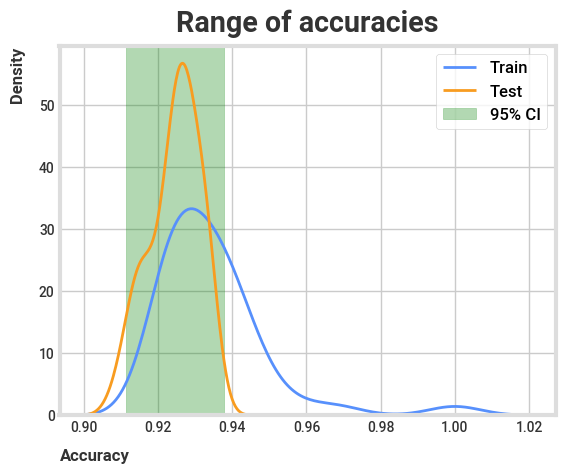

In [20]:
sns.kdeplot(bc_train_results, label='Train')
sns.kdeplot(bc_test_results, label='Test')

bc_mean = bc_test_results.mean()
bc_2std = bc_test_results.std() * 2

plt.axvspan(
    bc_mean - bc_2std, bc_mean + bc_2std,
    color='green', alpha=0.3, label="95% CI"
)
plt.title("Range of accuracies")
plt.xlabel("Accuracy")
plt.grid()
plt.legend()

Out of curiosity, I tried with 500 trials, and another one with 1 - 400 n neighbors

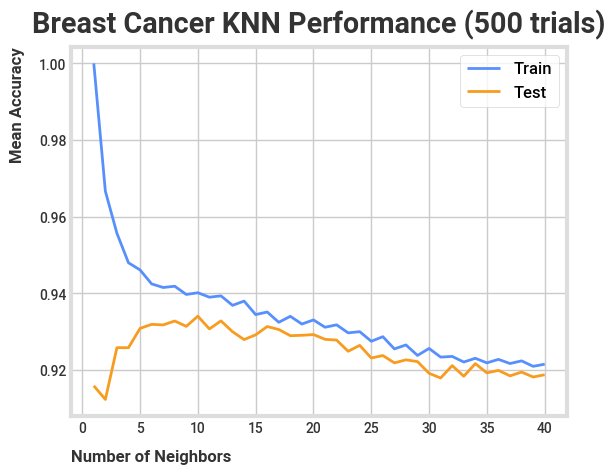

In [21]:
display(Image.open(FIGURES_DIR / "1.0_KNN-Implementation" / "bc_knn_500t_1-40k.png"))

One peculiar observation can be made about the spikes of the accuracy is that it seems that the KNN classifer performs better when the number of n neighbors are even.

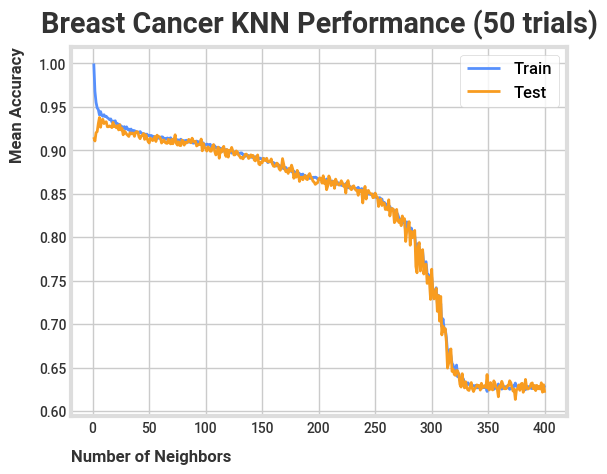

In [22]:
display(Image.open(FIGURES_DIR / "1.0_KNN-Implementation" / "bc_knn_50t_1-400k.png"))

The accuracy heavily drops off after 250 n neighbors, which is about half of the total samples within the dataset

In [23]:
y_cancer.shape

(569,)

Now that we have an accuracy of about 92%-93%, we can use this as a baseline, when we start doing some feature engineering, right now we are using 30 features, maybe we could try next time to reduce that and see the performance.

Normally, one wouldn't build a model before feature engineering, but due to innovations in computation and the size of this dataset, it is a trivial matter.

<a id="upcat"></a>
## UPCAT Dataset

In [24]:
# Load the data
X_upcat, y_upcat = DataLoader().load_upcat(EXTERNAL_DATA_DIR / "UPCAT_DATA2.xlsx")

upcat = (
    X_upcat.with_columns(target=y_upcat)
)

In [25]:
upcat.head()

Batch,Eng7,Eng8,Eng9,Math7,Math8,Math9,Sci7,Sci8,Sci9,GWA7,GWA8,GWA9,UP,IQ,SA,C1,C2,target
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64
2005,77,82,86,94,87,92,84,80,92,1.4764,1.5045,1.4098,1,55,28,1,4,1
2005,57,57,59,55,46,57,53,45,53,2.6557,2.7,2.7008,1,38,19,5,3,0
2005,55,52,55,57,53,51,57,62,51,2.6132,2.6818,2.7172,0,17,9,5,6,0
2005,69,78,78,87,79,79,83,82,79,1.7217,1.6136,1.7049,1,45,28,1,4,0
2005,64,71,68,71,57,54,60,59,55,2.4245,2.4318,2.4713,1,67,56,1,5,0


In [26]:
upcat.describe()

statistic,Batch,Eng7,Eng8,Eng9,Math7,Math8,Math9,Sci7,Sci8,Sci9,GWA7,GWA8,GWA9,UP,IQ,SA,C1,C2,target
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0,1004.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2009.313745,70.658367,71.378486,72.098606,74.598606,71.158367,71.471116,75.814741,73.574701,72.262948,1.989086,3.832594,2.103024,0.555777,65.625498,55.23506,1.193227,3.932271,0.476096
"""std""",2.900162,10.280794,10.832182,10.231578,12.299326,12.724625,12.935308,10.116251,12.233333,11.861303,0.381299,57.313019,1.809353,0.520637,20.177211,24.935421,0.681996,1.037384,0.499677
"""min""",2005.0,44.0,31.0,47.0,40.0,41.0,41.0,52.0,0.0,42.0,0.98,1.0727,1.1895,0.0,10.0,4.0,1.0,1.0,0.0
"""25%""",2007.0,63.0,63.0,64.0,65.0,61.0,61.0,69.0,64.0,63.0,1.7075,1.7273,1.754,0.0,52.0,34.0,1.0,4.0,0.0
"""50%""",2009.0,71.0,72.0,73.0,76.0,70.0,71.0,76.0,74.0,72.0,1.9706,2.0182,2.0444,1.0,69.0,56.0,1.0,4.0,0.0
"""75%""",2012.0,79.0,80.0,80.0,84.0,81.0,82.0,84.0,83.0,81.0,2.2689,2.3145,2.3361,1.0,81.0,76.0,1.0,4.0,1.0
"""max""",2014.0,96.0,97.0,98.0,99.0,99.0,99.0,98.0,100.0,100.0,2.9804,1818.0,58.1129,2.0,99.0,99.0,9.0,9.0,1.0


In [27]:
upcat['target'].value_counts()

target,count
i64,u32
0,526
1,478


We have 2 classes and considering there is no data dictionary, we will have work to with just guessing and some light research. [Wikipedia link](https://en.wikipedia.org/wiki/University_of_the_Philippines_College_Admission_Test)

The positive class means that a student is eligible for the University of the Philippines College Admission Test (UPCAT). And the negative class is otherwise.



We plot the interactions using a heatmap instead of pairplot as we have 18 features.

<Axes: >

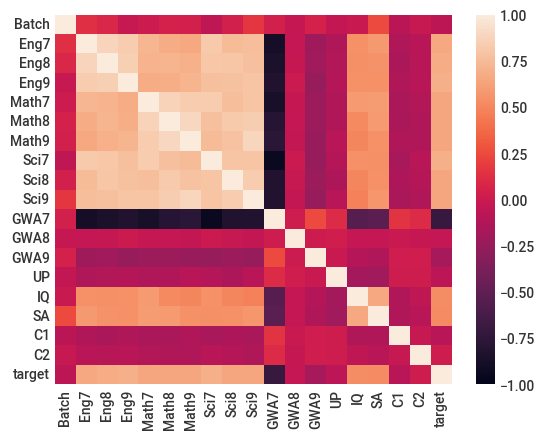

In [28]:
sns.heatmap(upcat.to_pandas().corr(), annot=False, vmin=-1, vmax=1)

We can see that we have some features, that are not correlated with our target, that gives us options to remove them entirely in our model. However, I will leave them be for now to see the performance and use that as a baseline for comparison.

### KNN Implementation and Discussion

Let's build our KNN Pipeline and try to discuss the results.

2025-02-20 00:43:34.718 | INFO     | __main__:grid_search:47 - Starting Grid Search for UPCAT. n_neighbors: range(1, 41), trials: 50


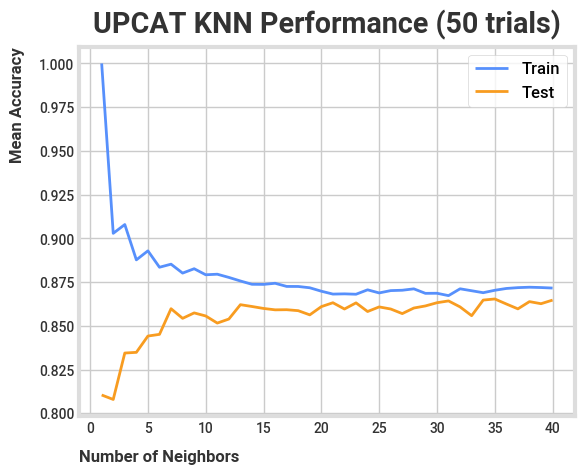

2025-02-20 00:45:22.385 | INFO     | __main__:grid_search:68 - Finished Grid Search for UPCAT
 Train max accuracy: 1.0
 Test max accuracy: 0.8653386454183266


In [29]:
upcat_KNN = KNNPipeline(X_upcat, y_upcat, "UPCAT")

upcat_results = upcat_KNN.grid_search(range(1, 41), trials=50, plot=True, test_size=0.25)

In [30]:
upcat_train_results, upcat_test_results, _, upcat_chart = upcat_results
print(f"""
Training set:
    Best n_neighbor: {upcat_train_results.argmax() + 1}
    Best accuracy: {upcat_train_results.max()}
    Mean of means: {upcat_train_results.mean()}
    Std of means: {upcat_train_results.std()}

Test set:
    Best n_neighbor: {upcat_test_results.argmax() + 1}
    Best accuracy: {upcat_test_results.max()}
    Mean of means: {upcat_test_results.mean()}
    Std of means: {upcat_test_results.std()}
""")


Training set:
    Best n_neighbor: 1
    Best accuracy: 1.0
    Mean of means: 0.878546480743692
    Std of means: 0.02143312907070639

Test set:
    Best n_neighbor: 35
    Best accuracy: 0.8653386454183266
    Mean of means: 0.855418326693227
    Std of means: 0.012715805880047885



We have a mean accuracy of 0.855 and standard deviation of 0.0127. This model seems to be less accurate compared to the previous ones. However, we can set this accuracy as baseline for comparison when we try to improve our model.

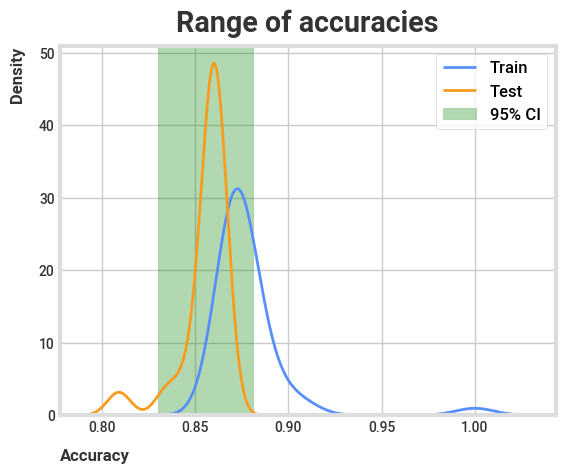

In [31]:
sns.kdeplot(upcat_train_results, label='Train')
sns.kdeplot(upcat_test_results, label='Test')

upcat_mean = upcat_test_results.mean()
upcat_2std = upcat_test_results.std() * 2

plt.axvspan(
    upcat_mean - upcat_2std, upcat_mean + upcat_2std,
    color='green', alpha=0.3, label="95% CI"
)
plt.title("Range of accuracies")
plt.xlabel("Accuracy")
plt.grid()
plt.legend()

## Discussion and Conclusion



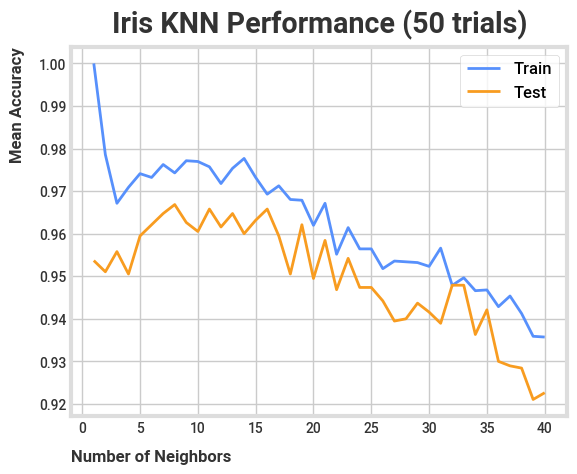

In [33]:
iris_chart

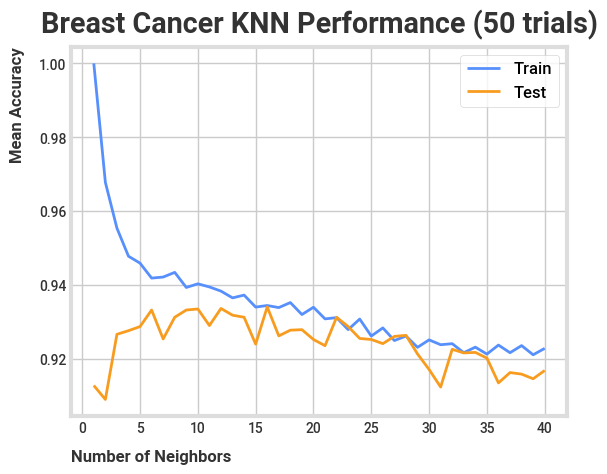

In [34]:
bc_chart

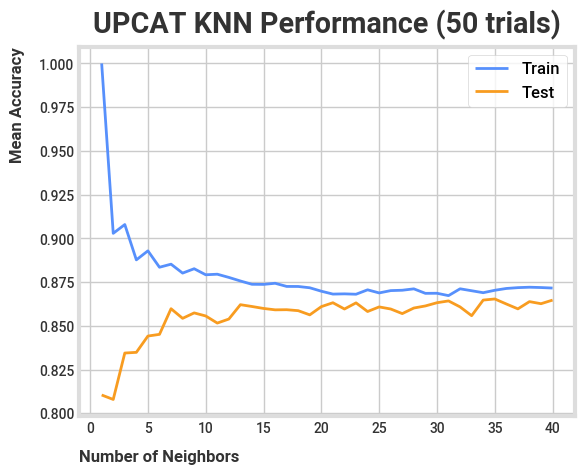

In [35]:
upcat_chart

In [38]:
iris.shape, breast_cancer.shape, upcat.shape

((150, 5), (569, 31), (1004, 19))

Common Observations:

- Test sets lag behind the training sets.
- As the number of neighbors increases, the model's performance decreases. One possible reason for this is the limited amount of data.
- The UPCAT dataset, having more samples, produces a more stable output (smoother lines) and is closer to the expected value compared to the other two datasets, which exhibit higher variance.
- The point at which accuracy converges remains unclear due to the limited amount of data and unexplored hyperparameters.


Future Improvements:

- This analysis was conducted without feature engineering, yet accuracies were consistently around **90%**. This accuracy can serve as a baseline for comparison when feature engineering is applied to assess potential improvements.